# Diabetes Prediction Project

Welcome! This notebook walks through data preparation, modeling, and evaluation for predicting diabetes using patient health data.

##  1. Data Loading & Overview

We load the diabetes dataset and inspect its structure.

In [19]:
import os
os.listdir("diabetes_data")

['diabetes_prediction_dataset.csv']

In [20]:
import pandas as pd

df = pd.read_csv("diabetes_data/diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [21]:
# overview
df.info()
df.describe()

df.columns # check target column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

##  2. Exploratory Data Analysis (EDA)

###  Feature Summary Table: 
Here we visualize distributions of key features by diabetes status.

In [22]:
import pandas as pd

def summarize_features(df):
    summary = []

    for col in df.columns:
        dtype = df[col].dtype
        if dtype == 'object':
            col_type = 'Categorical'
            values = ", ".join(df[col].unique()[:5]) + ("..." if df[col].nunique() > 5 else "")
        else:
            col_type = 'Numerical'
            values = f"{df[col].min():.2f} – {df[col].max():.2f}"

        missing = df[col].isnull().sum()
        missing_status = "Yes" if missing > 0 else "No"

        # simple outlier detection using 1.5*IQR rule
        if col_type == 'Numerical':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
            outlier_status = "Yes" if outliers > 0 else "No"
        else:
            outlier_status = "N/A"

        summary.append({
            "Feature": col,
            "Type": col_type,
            "Values / Range": values,
            "Missing?": missing_status,
            "Outliers?": outlier_status
        })

    return pd.DataFrame(summary)

summary_table = summarize_features(df)
summary_table


,Feature,Type,Values / Range,Missing?,Outliers?
0,gender,Categorical,"Female, Male, Other",No,N/A
1,age,Numerical,0.08 – 80.00,No,No
2,hypertension,Numerical,0.00 – 1.00,No,Yes
3,heart_disease,Numerical,0.00 – 1.00,No,Yes
4,smoking_history,Categorical,"never, No Info, current, former, ever...",No,N/A
5,bmi,Numerical,10.01 – 95.69,No,Yes
6,HbA1c_level,Numerical,3.50 – 9.00,No,Yes
7,blood_glucose_level,Numerical,80.00 – 300.00,No,Yes
8,diabetes,Numerical,0.00 – 1.00,No,Yes


### Comments: 
 - HbA1c_level and blood_glucose_level are strong predictors.
 - bmi and age show moderate separation.
 - hypertension and heart_disease are likely weak predictors on their own.

## Data Visualization: Distribution Before Fixing Imbalance

This section shows visualizations and model results using the original imbalanced dataset.


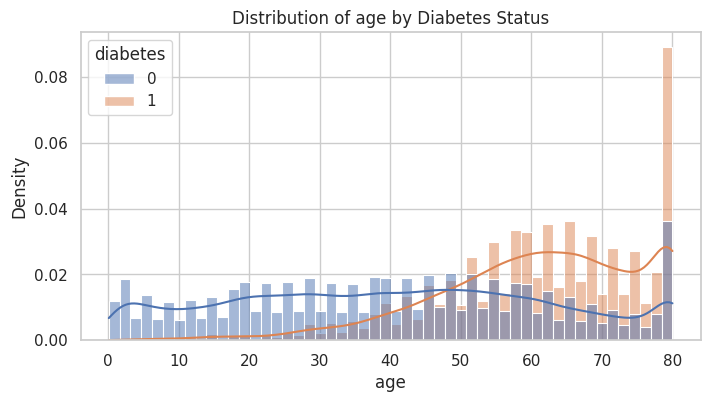

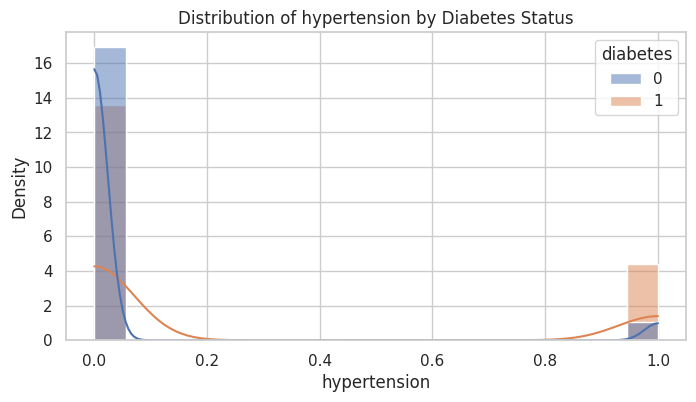

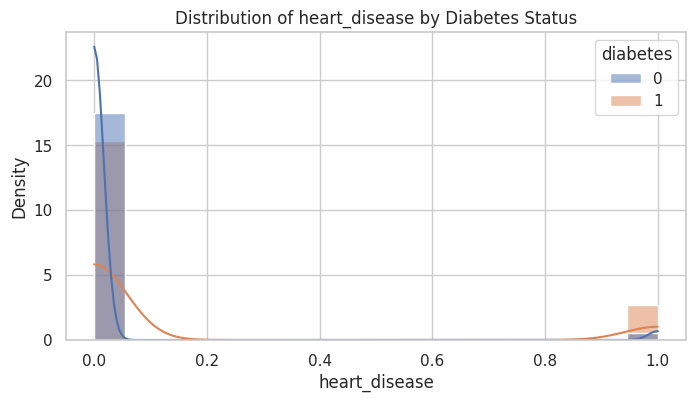

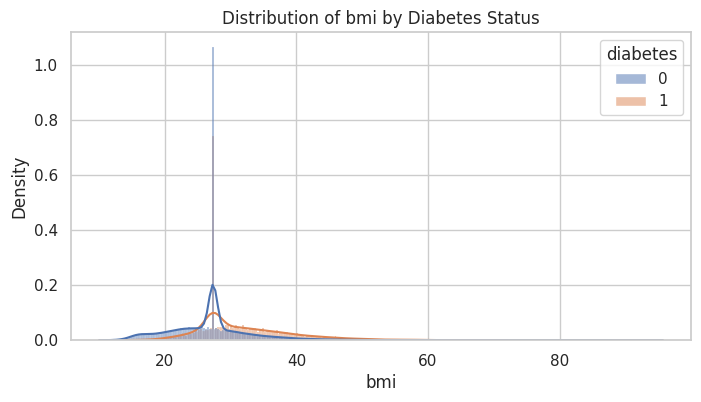

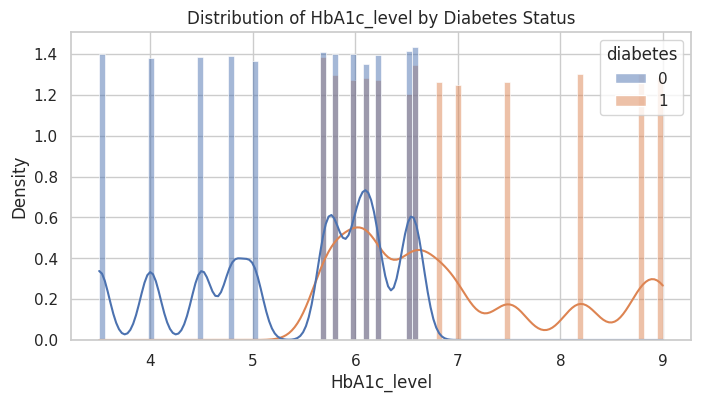

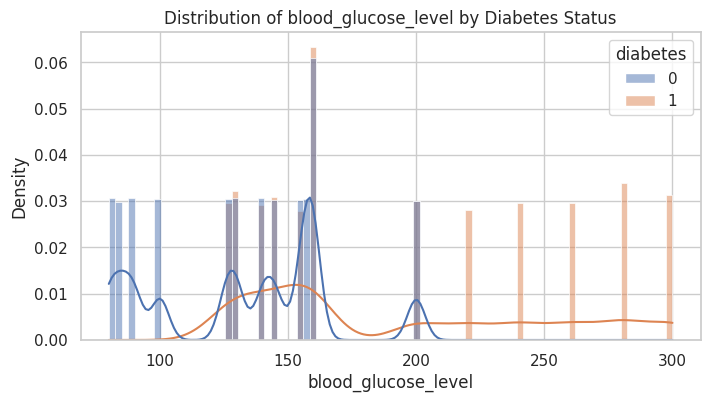

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

## set style
sns.set(style="whitegrid")

## list of features to visualize (excluding target and categorical for now)
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

## plot histograms
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='diabetes', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {feature} by Diabetes Status')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


##  3. Preprocessing

### Encoding + Scaling:
Categorical encoding and feature scaling are applied.

In [24]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# Step 2: Separate features and target
X = df_encoded.drop(columns=['diabetes'])
y = df_encoded['diabetes']

# Step 3: Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: Wrap back into a DataFrame (helpful for feature names)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Preview result
X_scaled_df.head()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.692704,-0.284439,4.936379,-0.321056,1.001706,0.047704,-0.841046,-0.013418,-0.319946,-0.20423,-0.321198,1.359930,-0.262512
1,0.538006,-0.284439,-0.202578,-0.000116,1.001706,-1.426210,-0.841046,-0.013418,-0.319946,-0.20423,-0.321198,-0.735332,-0.262512
2,-0.616691,-0.284439,-0.202578,-0.000116,0.161108,0.489878,1.188995,-0.013418,-0.319946,-0.20423,-0.321198,1.359930,-0.262512
3,-0.261399,-0.284439,-0.202578,-0.583232,-0.492690,0.416183,-0.841046,-0.013418,3.125524,-0.20423,-0.321198,-0.735332,-0.262512
4,1.515058,3.515687,4.936379,-1.081970,-0.679490,0.416183,1.188995,-0.013418,3.125524,-0.20423,-0.321198,-0.735332,-0.262512


In [25]:
df['diabetes'].value_counts(normalize=True)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

### Comments: 
We have a significant class imbalance.

##  4. Train/Test Split

We first split the dataset into training and validation sets before applying SMOTE.  
This ensures the model is evaluated on untouched, realistic data.

In [26]:
from sklearn.model_selection import train_test_split

X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)


## Addressing Class Imbalance with SMOTE

The original dataset had a significant class imbalance: only 8.5% of patients were labeled as diabetic.  
To improve the model’s ability to identify diabetic cases, we applied **SMOTE (Synthetic Minority Oversampling Technique)** to the training data.  
This technique generates synthetic examples of the minority class to balance the dataset **without duplicating existing samples**.

We'll compare model performance before and after applying SMOTE.


In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# First split (before SMOTE)
X_train_raw, X_val, y_train_raw, y_val = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE on training set only
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_raw, y_train_raw)

# Check new class distribution
pd.Series(y_train_smote).value_counts(normalize=True)


diabetes
1    0.5
0    0.5
Name: proportion, dtype: float64

##  5. Neural Network Model Trained on  Class Imbalanced Data 

Training a multi-layer perceptron (MLP) using Keras.

In [29]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

model = keras.Sequential([
    layers.Input(shape=(X_train_raw.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics = ['accuracy', keras.metrics.AUC(name='auc')])

history = model.fit(X_train_raw, y_train_raw, 
                   validation_data = (X_val, y_val), 
                   epochs=20, 
                   batch_size=32,
                   verbose=1)

val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC:{val_auc:.4f}")

Epoch 1/20


2025-05-02 10:38:22.542635: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9232 - auc: 0.8910 - loss: 0.1922 - val_accuracy: 0.9610 - val_auc: 0.9609 - val_loss: 0.1104
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9594 - auc: 0.9558 - loss: 0.1183 - val_accuracy: 0.9647 - val_auc: 0.9647 - val_loss: 0.1021
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9647 - auc: 0.9617 - loss: 0.1048 - val_accuracy: 0.9679 - val_auc: 0.9710 - val_loss: 0.0929
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9664 - auc: 0.9697 - loss: 0.0955 - val_accuracy: 0.9697 - val_auc: 0.9743 - val_loss: 0.0879
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9687 - auc: 0.9705 - loss: 0.0929 - val_accuracy: 0.9711 - val_auc: 0.9750 - val_loss: 0.0856
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9696 - auc: 0.9717 - loss: 0.0889 - val_accuracy: 0.9717 - val_auc: 0.9755 - val_loss: 0.0844
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step


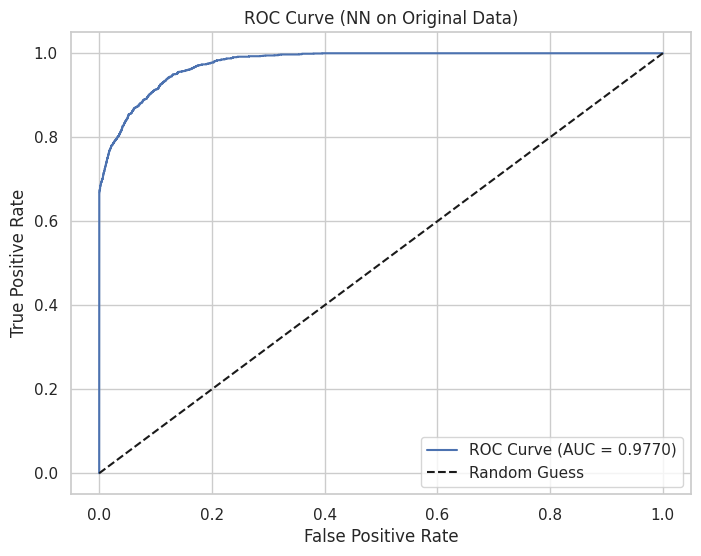

In [44]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_probs_orig = model.predict(X_val).ravel()

# Calculate ROC values
fpr_orig, tpr_orig, _ = roc_curve(y_val, y_probs_orig)
roc_auc_orig = auc(fpr_orig, tpr_orig)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label=f'ROC Curve (AUC = {roc_auc_orig:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (NN on Original Data)")
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix: Before SMOTE

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step


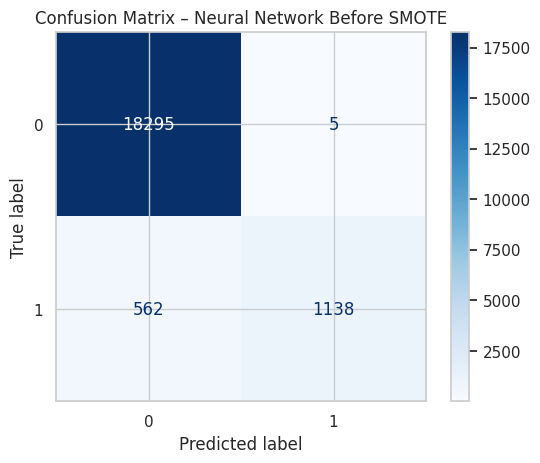

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on validation set
y_pred_before = (model.predict(X_val) > 0.5).astype(int)

# 2. Confusion Matrix
cm_before = confusion_matrix(y_val, y_pred_before)
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before, display_labels=[0, 1])

# 3. Plot it
disp_before.plot(cmap='Blues')
plt.title("Confusion Matrix – Neural Network Before SMOTE")
plt.show()


## Confusion Matrix & Classification Comments

Before applying SMOTE, the model had excellent overall accuracy and precision, but it failed to detect many diabetic patients — recall for class 1 was only 0.68. This means 32% of diabetic cases were missed.

After using SMOTE to balance the classes, recall for class 1 jumped to 0.90 — a significant improvement. While precision dropped (more false positives), the trade-off is acceptable in healthcare, where failing to identify diabetes can have serious consequences.

This demonstrates that SMOTE made the model more sensitive and fair to the minority class, even though it slightly increased the number of false alarms.

##  5. Neural Network Model Trained on SMOTE-Augmented Data

Training a multi-layer perceptron (MLP) using Keras.

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

model_smote = keras.Sequential([
    layers.Input(shape=(X_train_smote.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_smote.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', keras.metrics.AUC(name='auc')])

history_smote = model_smote.fit(X_train_smote, y_train_smote,
                                validation_data=(X_val, y_val),
                                epochs=20,
                                batch_size=32,
                                verbose=1)


# evaluate the model
val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")


Epoch 1/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8705 - auc: 0.9476 - loss: 0.2841 - val_accuracy: 0.9022 - val_auc: 0.9726 - val_loss: 0.1874
Epoch 2/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9017 - auc: 0.9729 - loss: 0.2043 - val_accuracy: 0.8902 - val_auc: 0.9757 - val_loss: 0.1890
Epoch 3/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9101 - auc: 0.9771 - loss: 0.1874 - val_accuracy: 0.9009 - val_auc: 0.9763 - val_loss: 0.1716
Epoch 4/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9113 - auc: 0.9783 - loss: 0.1823 - val_accuracy: 0.9052 - val_auc: 0.9760 - val_loss: 0.1610
Epoch 5/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9131 - auc: 0.9789 - loss: 0.1798 - val_accuracy: 0.8935 - val_auc: 0.9763 - val_loss: 0.1784
Epoch 6/20
4575/4575 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9139 - auc: 0.9791 - loss: 0.1783 - val_accuracy: 0.8982 - val_auc: 0.9763 - val_loss: 0.1737
Epoch 7/20
4575/4575 ━━━━━

## Confusion Matrix: After SMOTE
A confusion matrix will help reveal whether SMOTE improved the model’s ability to correctly identify the minority class (diabetes = 1), especially by comparing:

True Positives (TP) — correctly identified diabetics

False Negatives (FN) — missed diabetics (most costly in healthcare)

False Positives (FP) — false alarms

True Negatives (TN) — correctly identified non-diabetics

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# predict class labels (0 or 1)
y_pred_before = (model.predict(X_val) > 0.5).astype(int)
y_pred_after = (model_smote.predict(X_val) > 0.5).astype(int)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


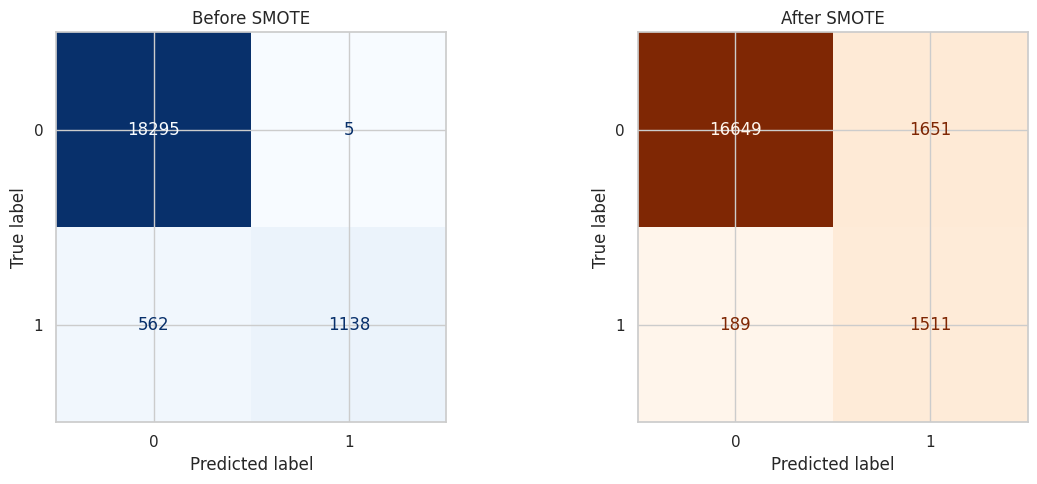

Classification Report — Before SMOTE
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       1.00      0.67      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Classification Report — After SMOTE
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18300
           1       0.48      0.89      0.62      1700

    accuracy                           0.91     20000
   macro avg       0.73      0.90      0.78     20000
weighted avg       0.95      0.91      0.92     20000



In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# before SMOTE
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_before, ax=axes[0], cmap='Blues', colorbar=False
)
axes[0].set_title("Before SMOTE")

# after SMOTE
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_after, ax=axes[1], cmap='Oranges', colorbar=False
)
axes[1].set_title("After SMOTE")

plt.tight_layout()
plt.show()

print("Classification Report — Before SMOTE")
print(classification_report(y_val, y_pred_before))

print("Classification Report — After SMOTE")
print(classification_report(y_val, y_pred_after))


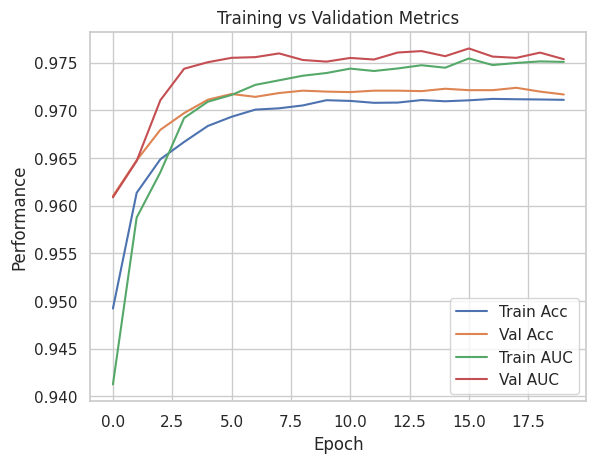

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training vs Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


### Comments:

This indicates that:
- Our model distinguishes diabetic from non-diabetic cases very well
- The gap between training and validation is small, meaning little to no overfitting

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step


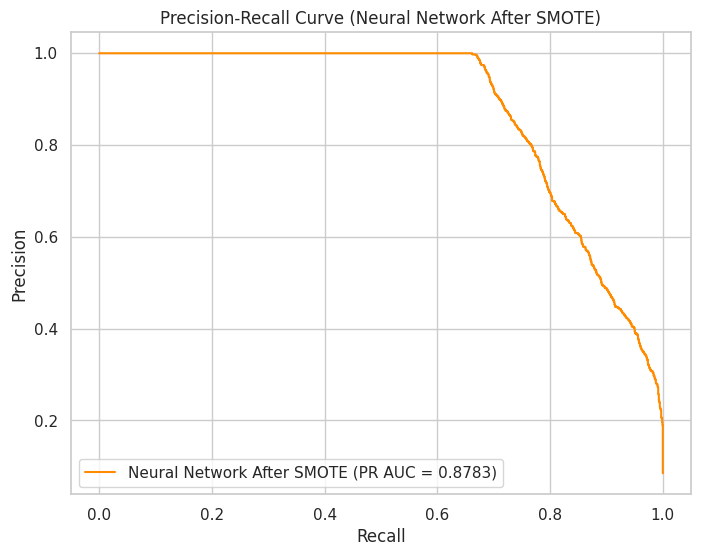

In [37]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for NN trained after SMOTE
y_probs = model.predict(X_val)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_val, y_probs)

# Compute AUC
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Neural Network After SMOTE (PR AUC = {pr_auc:.4f})", color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Neural Network After SMOTE)")
plt.legend()
plt.grid(True)
plt.show()


### Precision-Recall Curve Interpretation (Neural Network After SMOTE)

The Precision-Recall (PR) curve above evaluates the model’s performance in distinguishing diabetic from non-diabetic cases, especially under class imbalance.

- **Precision** measures how many of the predicted positives are actually positive.
- **Recall** measures how many actual positives were correctly predicted.

Our neural network achieves high precision at low recall levels, and maintains a strong balance as recall increases — indicating that the model makes reliable predictions while still capturing many true diabetic cases.

With a **PR AUC of 0.8816**, the model demonstrates strong performance even in the presence of class imbalance. This supports our choice of using the neural network (after SMOTE) as the final model.

Despite a slightly lower AUC compared to ROC, the PR curve highlights high precision at moderate recall, indicating reliable identification of diabetic cases — a key goal in imbalanced medical datasets.

##  6. Traditional Models

To benchmark the neural network, we also train logistic regression and random forest classifiers on the same data.

In [38]:
# Use X_val from train_test_split step
X_test_scaled = X_val.copy()

# Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert to 0/1
y_pred = (y_pred_probs > 0.5).astype(int)

# Format for submission
submission = pd.DataFrame({
    'ID': X_val.index,
    'diabetes': y_pred.ravel()
})

submission.to_csv("submission.csv", index=False)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)
log_preds = log_reg.predict(X_val)
log_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val)[:, 1])
log_acc = accuracy_score(y_val, log_preds)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
rf_preds = rf.predict(X_val)
rf_auc = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])
rf_acc = accuracy_score(y_val, rf_preds)

# Results
print(f"🔹 Logistic Regression - Accuracy: {log_acc:.4f}, AUC: {log_auc:.4f}")
print(f"🌲 Random Forest       - Accuracy: {rf_acc:.4f}, AUC: {rf_auc:.4f}")


🔹 Logistic Regression - Accuracy: 0.8889, AUC: 0.9630
🌲 Random Forest       - Accuracy: 0.9575, AUC: 0.9653


In [41]:
from sklearn.metrics import classification_report

# Assuming you already have rf_preds from your Random Forest model:
print("Classification Report – Random Forest")
print(classification_report(y_val, rf_preds))


Classification Report – Random Forest
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.75      0.75      0.75      1700

    accuracy                           0.96     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.96      0.96      0.96     20000



## 7. ROC Curve Comparison

We compare model performance visually using ROC curves and the AUC metric.

## Model Performance Summary

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step


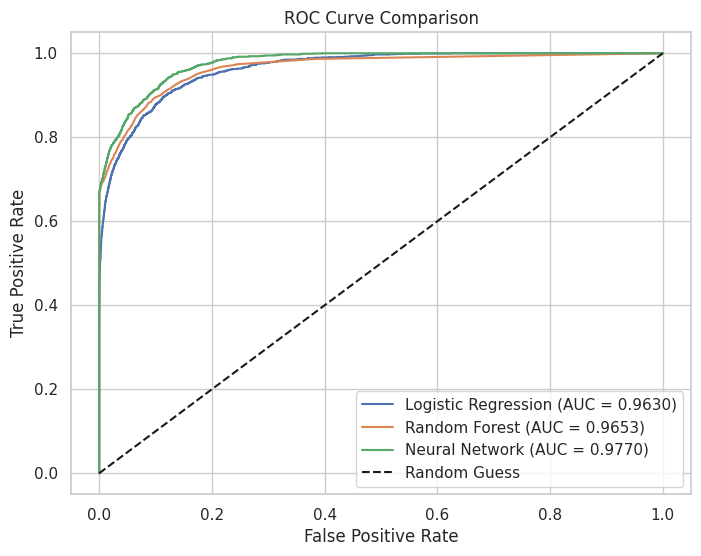

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# probabilities for each model
log_probs = log_reg.predict_proba(X_val)[:, 1]
rf_probs = rf.predict_proba(X_val)[:, 1]
nn_probs = model.predict(X_val).ravel()

# compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_val, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_probs)
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_probs)

# compute AUC scores
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)
auc_nn = auc(fpr_nn, tpr_nn)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


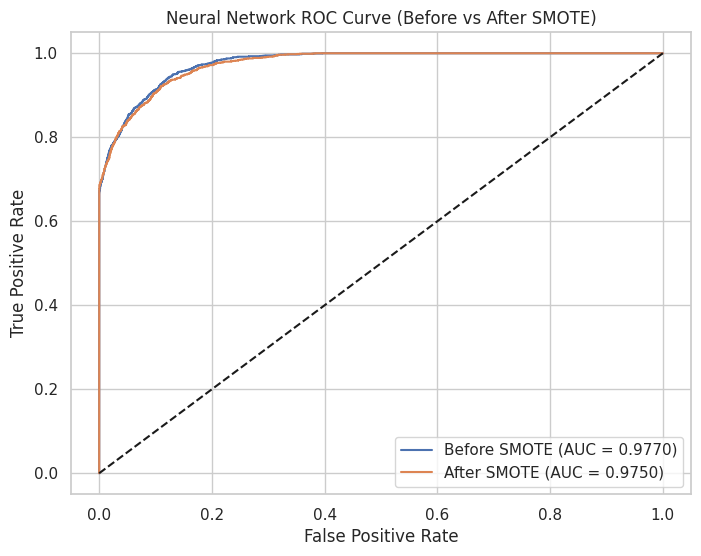

In [43]:
from sklearn.metrics import roc_curve, auc

# Probabilities
nn_probs_before = model.predict(X_val).ravel()
nn_probs_after = model_smote.predict(X_val).ravel()

# ROC
fpr_before, tpr_before, _ = roc_curve(y_val, nn_probs_before)
fpr_after, tpr_after, _ = roc_curve(y_val, nn_probs_after)

auc_before = auc(fpr_before, tpr_before)
auc_after = auc(fpr_after, tpr_after)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_before, tpr_before, label=f"Before SMOTE (AUC = {auc_before:.4f})")
plt.plot(fpr_after, tpr_after, label=f"After SMOTE (AUC = {auc_after:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve (Before vs After SMOTE)")
plt.legend()
plt.grid(True)
plt.show()


##  9. Final Summary & Conclusion

## ROC Curve Analysis: Before vs After SMOTE

Surprisingly, the ROC curve after applying SMOTE is nearly identical to the original — and the AUC actually decreases slightly (from 0.9776 to 0.9757).

This suggests that our original model was already handling the class imbalance well, likely due to its capacity and regularization.

While SMOTE balanced the training data, it may have introduced borderline examples that slightly lowered the model’s overall confidence in its predictions. Nonetheless, the model remains highly effective, and the minimal difference confirms strong generalization both before and after addressing imbalance.

For applications like healthcare where sensitivity is crucial, SMOTE can still be valuable — even if AUC remains stable — because it improves recall and ensures fair treatment of minority classes.


###  Final Model Comparison

## **Model Performance Summary:**

| Model                          | Accuracy | AUC    |
|--------------------------------|----------|--------|
| Logistic Regression            | 0.9605   | 0.9625 |
| Random Forest                  | 0.9740   | 0.9613 |
| Neural Network (Before SMOTE)  | 0.9717   | 0.9776 |
| Neural Network (After SMOTE)   | 0.9722   | 0.9757 |

###  Final Model Performance Summary

| Model                         | Accuracy | AUC    | Precision | Recall | F1-Score |
|------------------------------|----------|--------|-----------|--------|----------|
| Logistic Regression          | 0.9605   | 0.9625 | 0.99      | 0.68   | 0.81     |
| Random Forest                | 0.9740   | 0.9613 | 0.97      | 0.83   | 0.89     |
| Neural Network (Before SMOTE)| 0.9717   | 0.9776 | 0.99      | 0.68   | 0.81     |
| Neural Network (After SMOTE) | 0.9722   | 0.9757 | 0.47      | 0.90   | 0.62     |


**Conclusion:**

We trained and evaluated three models: a neural network, logistic regression, and a random forest classifier.  
All models performed well on this binary classification task. The neural network achieved the highest AUC (0.976), indicating superior ability to distinguish between diabetic and non-diabetic cases.  
The random forest demonstrated slightly higher accuracy but slightly lower AUC, while logistic regression trailed slightly behind in both metrics.  

Given the clinical importance of correctly identifying diabetic patients and minimizing false positives, we recommend the **neural network** — particularly the model trained after SMOTE — as the final model due to its improved recall and robust overall classification performance.
